In [1]:
import hist
import pickle

import numpy as np
import mplhep as hep
import matplotlib.pyplot as plt
%matplotlib widget
hep.style.use('CMS')

import importlib

import sys
top_dir = '/afs/crc.nd.edu/user/a/atownse2/Public/RSTriPhoton/'
sys.path.append(top_dir)

from analysis.metadata import sample_info

plot_dir = top_dir + 'plots/combined/'

In [2]:
# Load the histograms
with open('../pkl/data_info.pkl', 'rb') as f:
    data_info = pickle.load(f)
with open('../pkl/signal_datasets.pkl', 'rb') as f:
    signal_datasets = pickle.load(f)

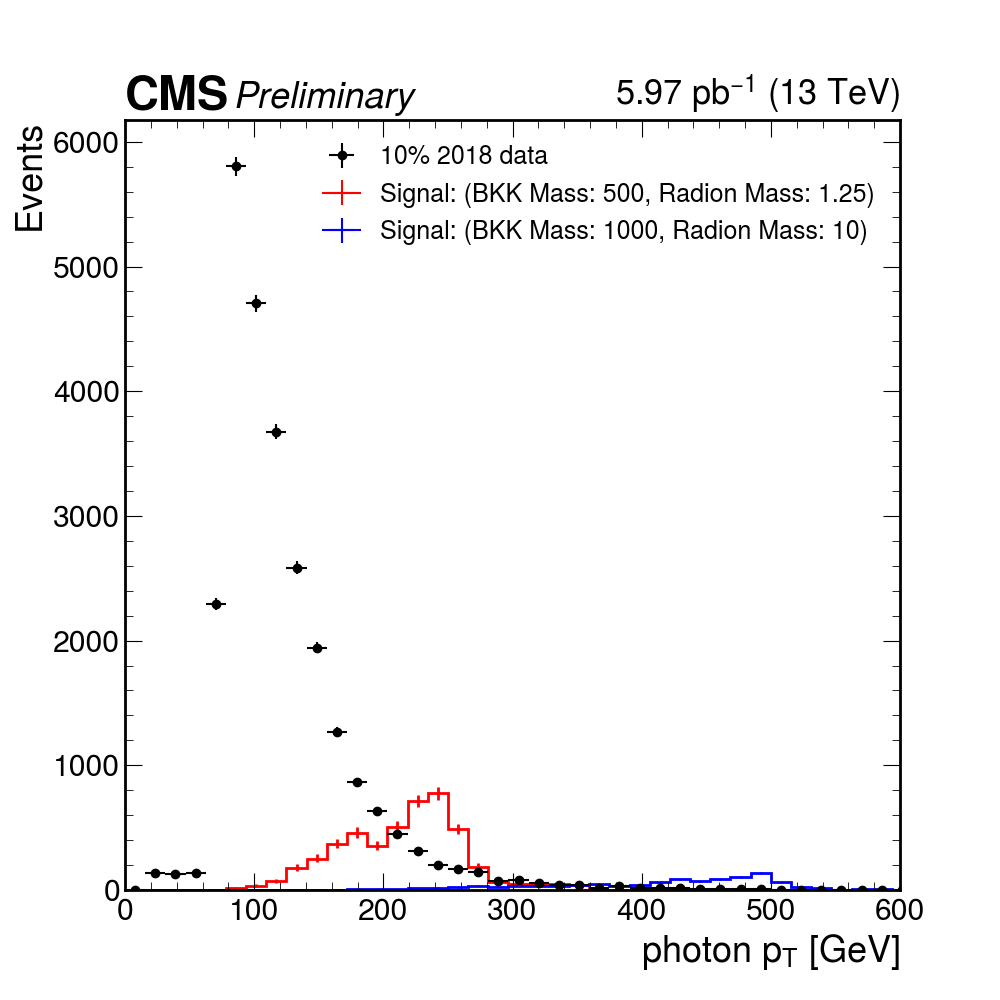

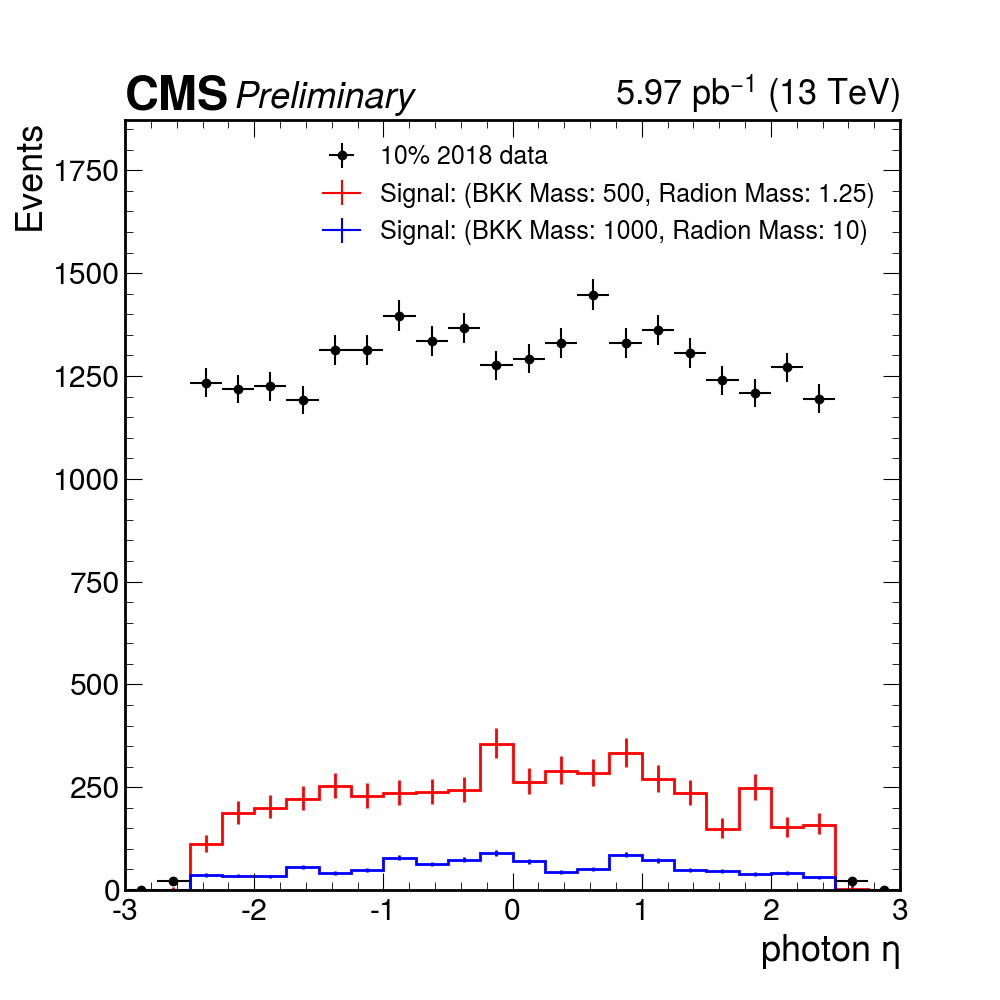

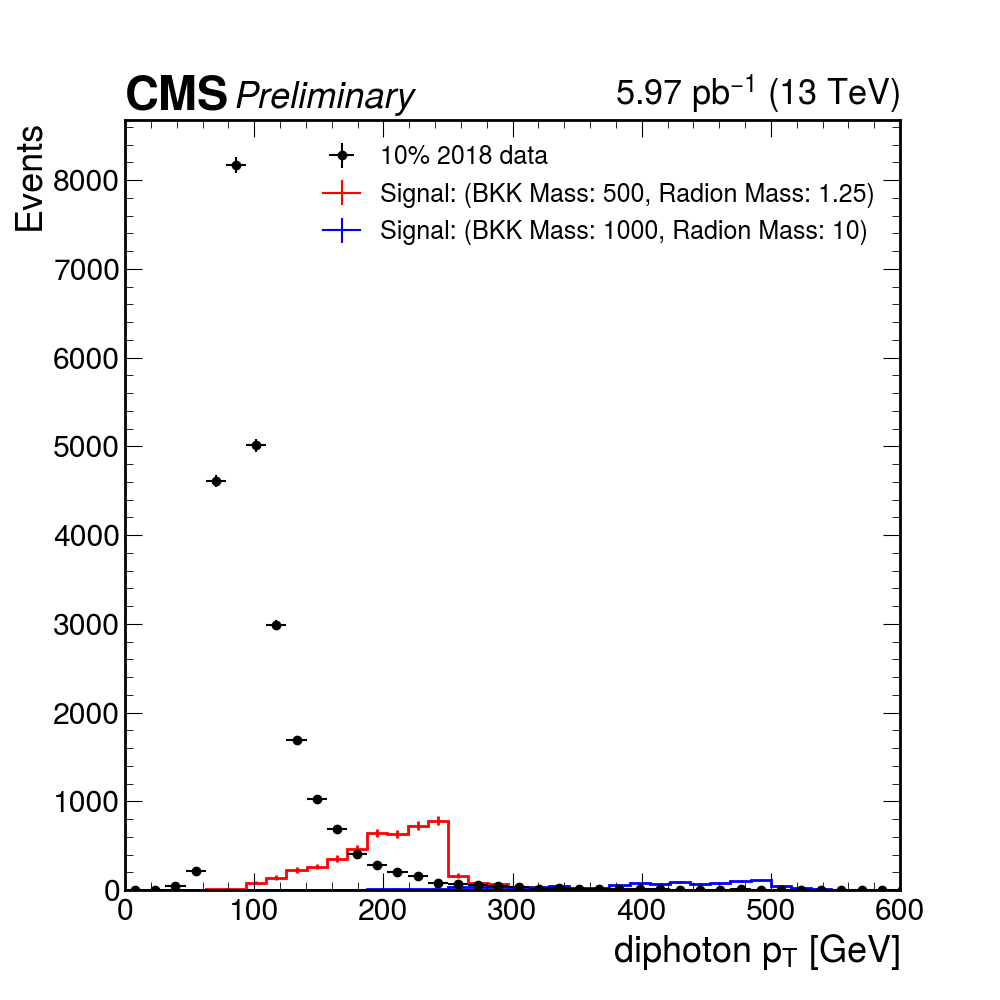

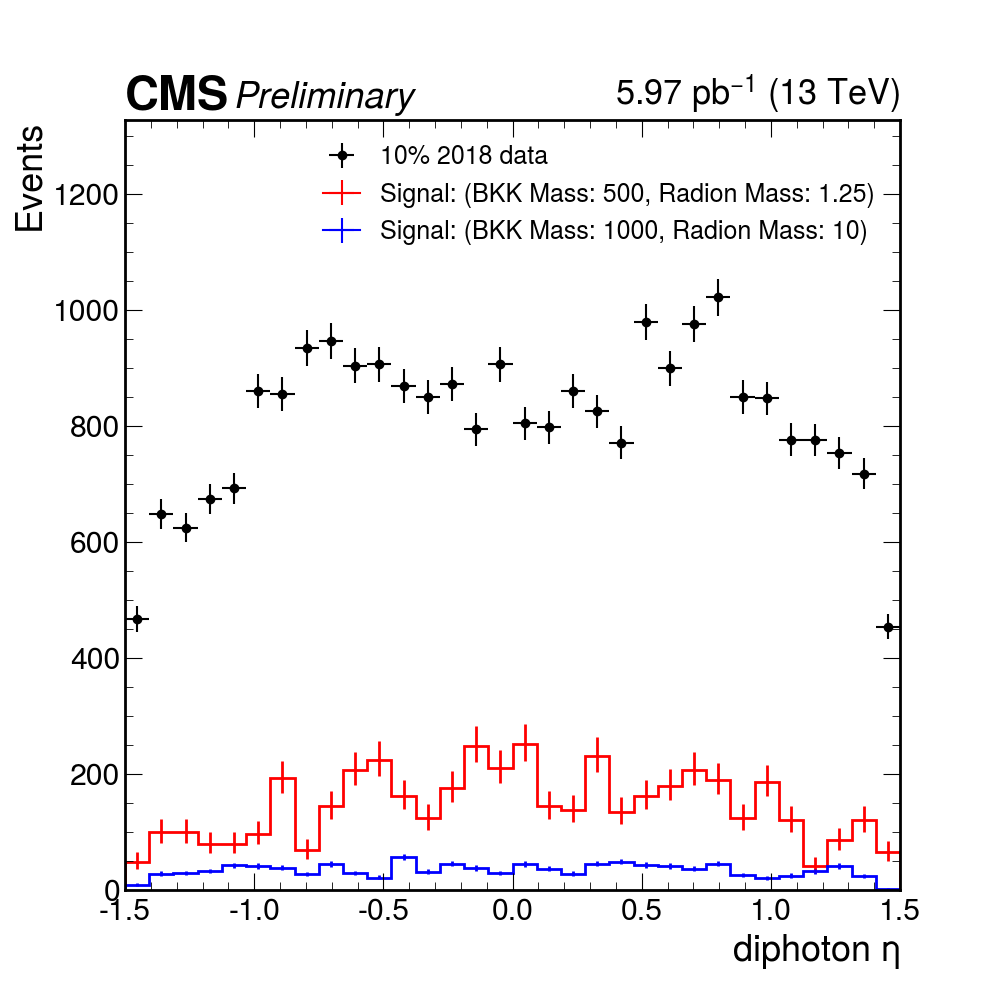

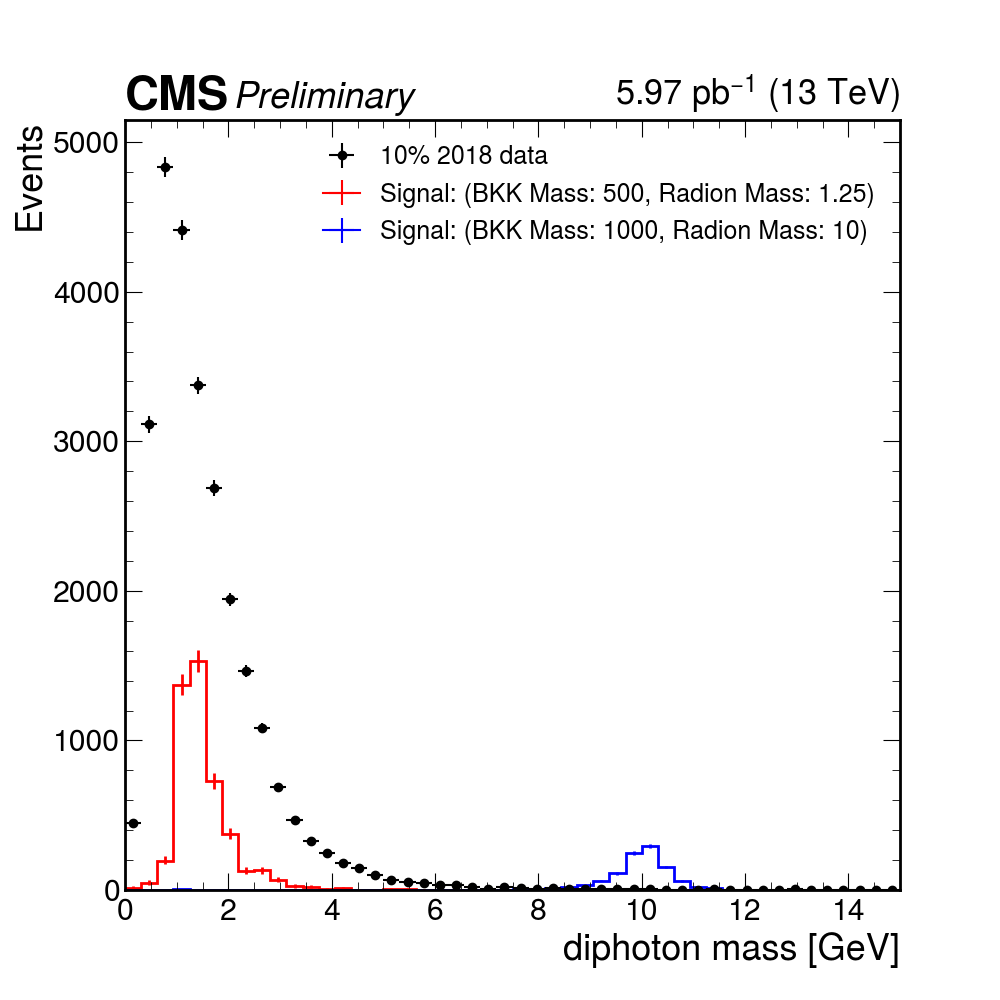

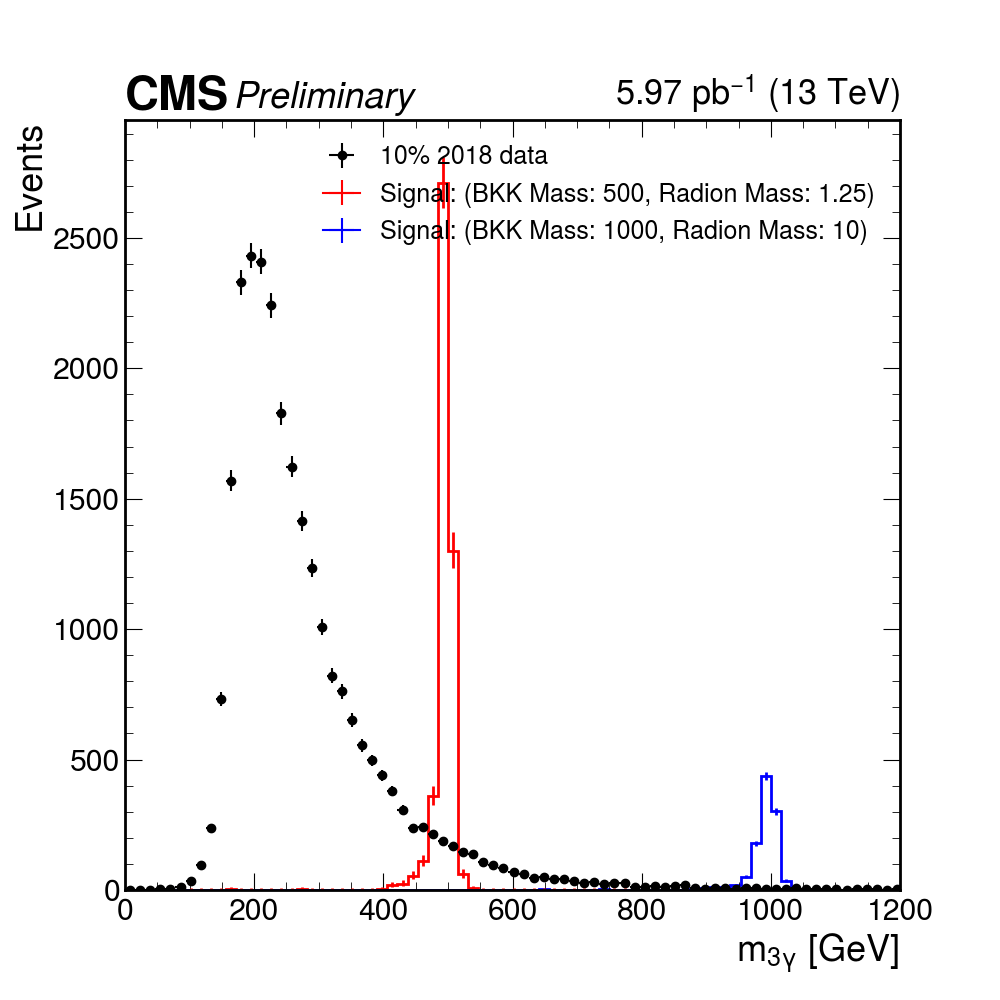

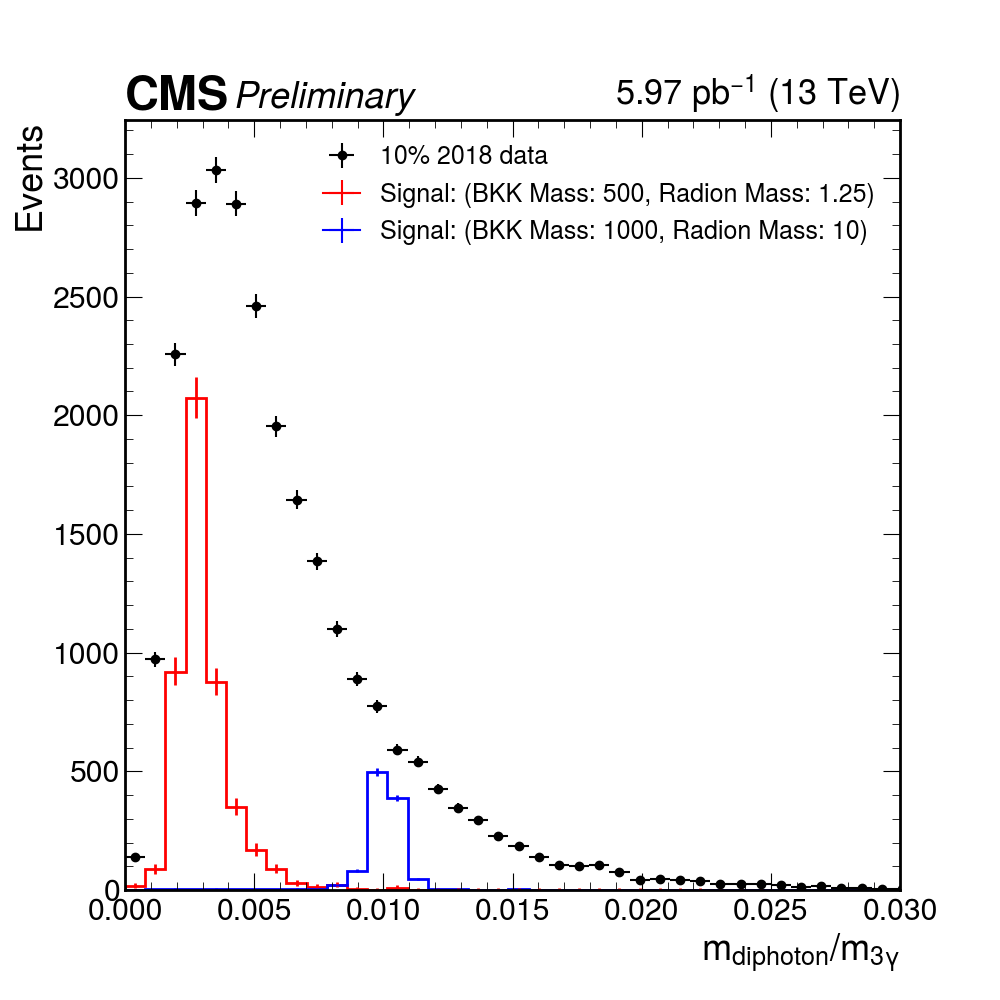

In [7]:
importlib.reload(sample_info)
# Clear figures
plt.close('all')
# Plot kinematic distributions with several signal points overlaid

vars = ['photon_pt', 'photon_eta', 'diphoton_pt', 'diphoton_eta', 'diphoton_mass', 'triphoton_mass', 'mass_ratio']
xlims = { 'photon_pt': (0, 600),
          'photon_eta': (-3, 3),
            'diphoton_pt': (0, 600),
            'diphoton_eta': (-1.5, 1.5),
          'diphoton_mass': (0, 15),
          'triphoton_mass': (0, 1200),
          'mass_ratio': (0, 0.03)}

ylims = { 'photon_eta': 'maxplus',
         'diphoton_eta': 'maxplus',
}

rebin = { 'photon_eta': 4,
            'diphoton_eta': 4,
}

colors = ['red', 'blue', 'purple']
lumi = data_info['lumi']
signal_points = [(500,1.25),(1000,10)]
for var in vars:
    fig, ax = plt.subplots()
    ax.set_ylabel('Events')
    

    # Plot the data
    h = data_info['hists'][var].copy()

    #hep.histplot(h, ax=ax, label='10% 2018 data', color='black')
    ax.errorbar(
        h.axes[0].centers,
        h.values(),
        xerr=0.5*h.axes[0].widths, 
        yerr=np.sqrt(h.values()),
        linestyle="None",
        color='black',
        marker='o',
        label='10% 2018 data')

    # Plot the signal
    for i, point in enumerate(signal_points):
        info = signal_datasets[point]
        signal_filetag = sample_info.get_signal_filetag(point)
        xs = sample_info.get_signal_cross_section(signal_filetag)['xs']*1000 # fb
        selection_efficiency = info['selection_efficiency_DoublePhoton70']
        scale = xs*selection_efficiency*lumi

        # For plotting, scale down the signal
        scale = scale/20

        # Scale the signal
        h = info['hists'][var].copy()
        h*=scale

        #h.plot(ax=ax, label='Signal: (BKK Mass: {}, Radion Mass: {})'.format(*point), color=colors[i])
        hep.histplot(
            h,
            ax=ax,
            label='Signal: (BKK Mass: {}, Radion Mass: {})'.format(*point),
            color=colors[i],
            linewidth=2,)

    # Set the axis limits
    if var in xlims:    
        ax.set_xlim(*xlims[var])
    if var in ylims:
        if ylims[var] == 'maxplus':
            ymax = ax.get_ylim()[1]
            ax.set_ylim(0, ymax*1.2)
        else:
            ax.set_ylim(*ylims[var])


    hep.cms.label(rlabel= str(np.round(lumi, decimals=2))+" pb$^{-1}$ (13 TeV)", ax=ax, llabel='Work In Progress', year='2018')
    ax.legend(loc='upper right', fontsize=18)
    fig.savefig(plot_dir + var + '.png')


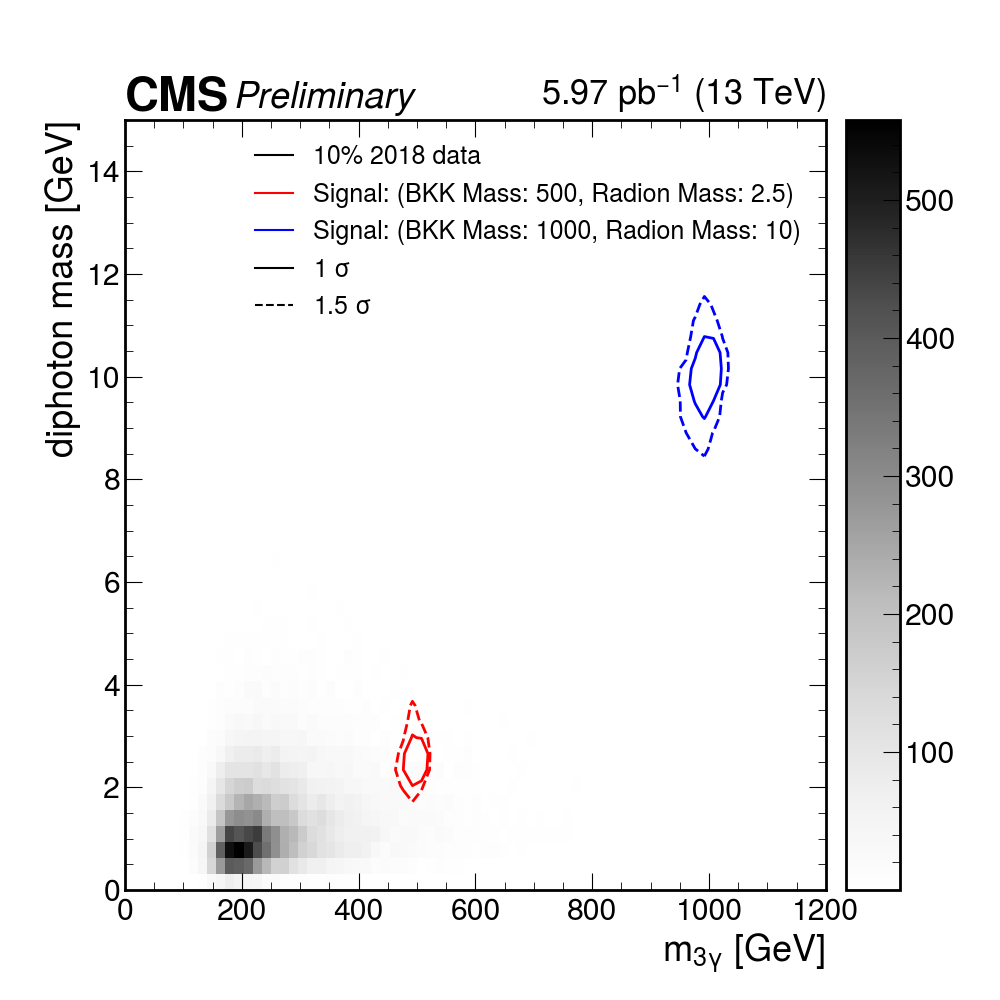

In [8]:
# Clear figures
plt.close('all')
# Plot the 2D histograms
fig, ax = plt.subplots()
signal_points = [(500,2.5),(1000,10)]
h = data_info['hists']['triphoton_diphoton_mass'].copy()
hep.hist2dplot(h, ax=ax, cmin=1e-3, cmap='Greys')
ax.plot([], [], color='black', label='10% 2018 data')
for i, point in enumerate(signal_points):
    # Signal label
    ax.plot([], [], color=colors[i], label='Signal: (BKK Mass: {}, Radion Mass: {})'.format(*point))

    # Plot 2D contour of the signal
    hists = signal_datasets[point]['hists']
    h = hists['triphoton_diphoton_mass'].copy()
    H, xedges, yedges = hists['triphoton_diphoton_mass'].to_numpy()

    # Normalize the histogram to represent a probability distribution
    H /= H.sum()

    # Get the values for the 1 sigma and 2 sigma contours
    sorted_indices = np.argsort(H, axis=None)[::-1]
    sorted_cumsum = np.cumsum(H.ravel()[sorted_indices])
    one_sigma_height = H.ravel()[sorted_indices][np.searchsorted(sorted_cumsum, 0.683)]
    two_sigma_height = H.ravel()[sorted_indices][np.searchsorted(sorted_cumsum, 0.867)]

    # Adjust the X and Y meshgrid values correctly for the contour plot
    X, Y = np.meshgrid(xedges[:-1] + np.diff(xedges)/2, yedges[:-1] + np.diff(yedges)/2)

    # Plot the 2D histogram with different bin sizes and the contours
    cont = ax.contour(
        X,
        Y,
        H.T, 
        levels=[two_sigma_height, one_sigma_height],
        colors=[colors[i]],
        linestyles=['dashed', 'solid'],
        linewidths=[2,2],)

ax.plot([], [], color = 'black', linestyle='solid', label='1 $\sigma$')
ax.plot([], [], color = 'black', linestyle='dashed', label='1.5 $\sigma$')

ax.set_xlim(0, 1200)
ax.set_ylim(0, 15)
ax.legend(loc='upper right', fontsize=18)
hep.cms.label(rlabel= str(np.round(lumi, decimals=2))+" pb$^{-1}$ (13 TeV)", ax=ax, llabel='Work In Progress', year='2018')
fig.savefig(plot_dir + 'triphoton_diphoton_mass.png')




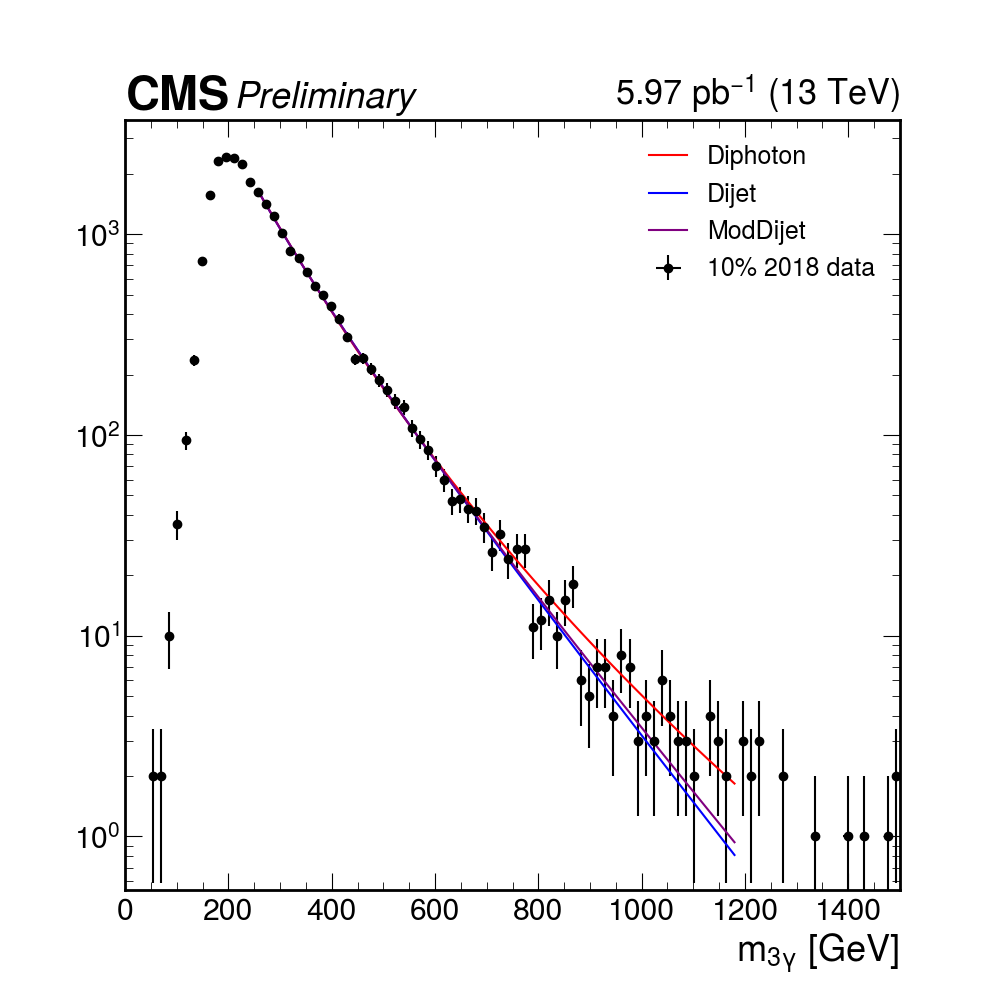

In [98]:
# Clear figures
plt.close('all')

# Plot the fits to the triphton mass distribution
fig, ax = plt.subplots()

h = data_info['hists']['triphoton_mass'].copy()
ax.errorbar(
        h.axes[0].centers,
        h.values(),
        xerr=0.5*h.axes[0].widths, 
        yerr=np.sqrt(h.values()),
        linestyle="None",
        color='black',
        marker='o',
        label='10% 2018 data' )

# Fit
colors = ['red', 'blue', 'purple']
from scipy.optimize import curve_fit, approx_fprime
def f_diphoton(x, p0=0, p1=0, p2=0):
    x=x/5000
    return p0*x**(p1+p2*np.log(x))
def f_dijet(x, p0=100, p1=1, p2=1):
    x=x/13000
    return p0*(1-x)**p1/x**p2
def f_moddijet(x, p0=1e9, p1=1, p2=1):
    x=x/5000
    return p0*(1-x**(1/3))**p1/x**p2

fits = {'Diphoton': {'func': f_diphoton, 'p0': [0, 0, 0]},
        'Dijet': {'func': f_dijet, 'p0': [100, 1, 1]},
        'ModDijet': {'func': f_moddijet, 'p0': [1e9, 1, 1]},
        }

# Fit the data between 200 and 1000 GeV
h_slice = h[250j:1200j]

x = h_slice.axes[0].centers
y = h_slice.values()

i=0
for name, fit_pars in fits.items():
    func = fit_pars['func']
    p0 = fit_pars['p0']

    # Use curve_fit to get the fit parameters
    popt, pcov = curve_fit(func, x, y, p0=p0)

    # Plot the fit
    ax.plot(x, func(x, *popt), color=colors[i], label=name)

    i+=1

ax.set_xlabel('$m_{3\gamma}$ [GeV]')
ax.legend(loc='upper right', fontsize=18)
ax.set_xlim(0,1500)
ax.set_yscale('log')
ax2.set_ylim(-2.5,2.5)
hep.cms.label(rlabel= str(np.round(lumi, decimals=2))+" pb$^{-1}$ (13 TeV)", ax=ax, llabel='Work In Progress', year='2018')
fig.savefig(plot_dir + 'triphoton_mass_fit.png')

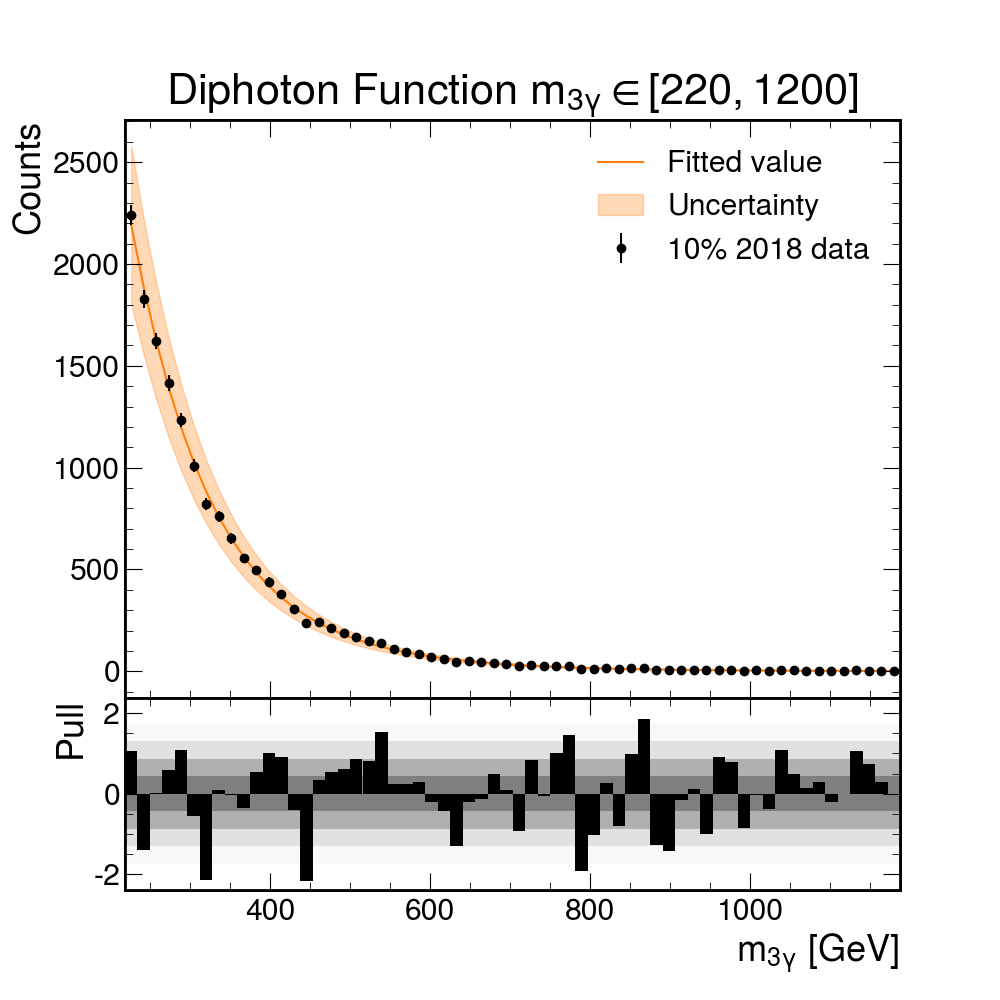

In [90]:
# Clear figures
plt.close('all')

# Plot the pull
fig, ax = plt.subplots()

# Remove axis labels from the main plot
ax.set_xticklabels([])
ax.set_yticklabels([])

# Make the fitted line label say diphoton
main, sub = h_slice.plot_pull(
    f_diphoton,
    eb_ecolor='black',
    eb_mfc='black',
    eb_mec='black',
    eb_label='10% 2018 data',
    bar_fc='black',
    pp_fc='black',
)
ax.set_title('Diphoton Function $m_{3\gamma}\in [220,1200]$')

fig.savefig(plot_dir + 'triphoton_mass_fit_diphoton_pull.png')